Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/15 - Loss: 1.5719
Epoch 2/15 - Loss: 1.3502
Epoch 3/15 - Loss: 1.2924
Epoch 4/15 - Loss: 1.2253
Epoch 5/15 - Loss: 1.0458
Epoch 6/15 - Loss: 0.8149
Epoch 7/15 - Loss: 0.6530
Epoch 8/15 - Loss: 0.5271
Epoch 9/15 - Loss: 0.3768
Epoch 10/15 - Loss: 0.3022
Epoch 11/15 - Loss: 0.2427
Epoch 12/15 - Loss: 0.2095
Epoch 13/15 - Loss: 0.1619
Epoch 14/15 - Loss: 0.1349
Epoch 15/15 - Loss: 0.1458

BERT Model Performance:
Accuracy: 0.6781

Classification Report:
                              precision    recall  f1-score   support

           Diabetic Friendly       0.00      0.00      0.00         5
                  Eggetarian       0.90      0.75      0.82        12
                 Gluten Free       0.00      0.00      0.00         1
 High Protein Non Vegetarian       0.00      0.00      0.00         3
     High Protein Vegetarian       0.29      0.50      0.37        10
No Onion No Garlic (Sattvic)       0.00      0.00      0.00         1
              Non Vegeterian       0.55      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


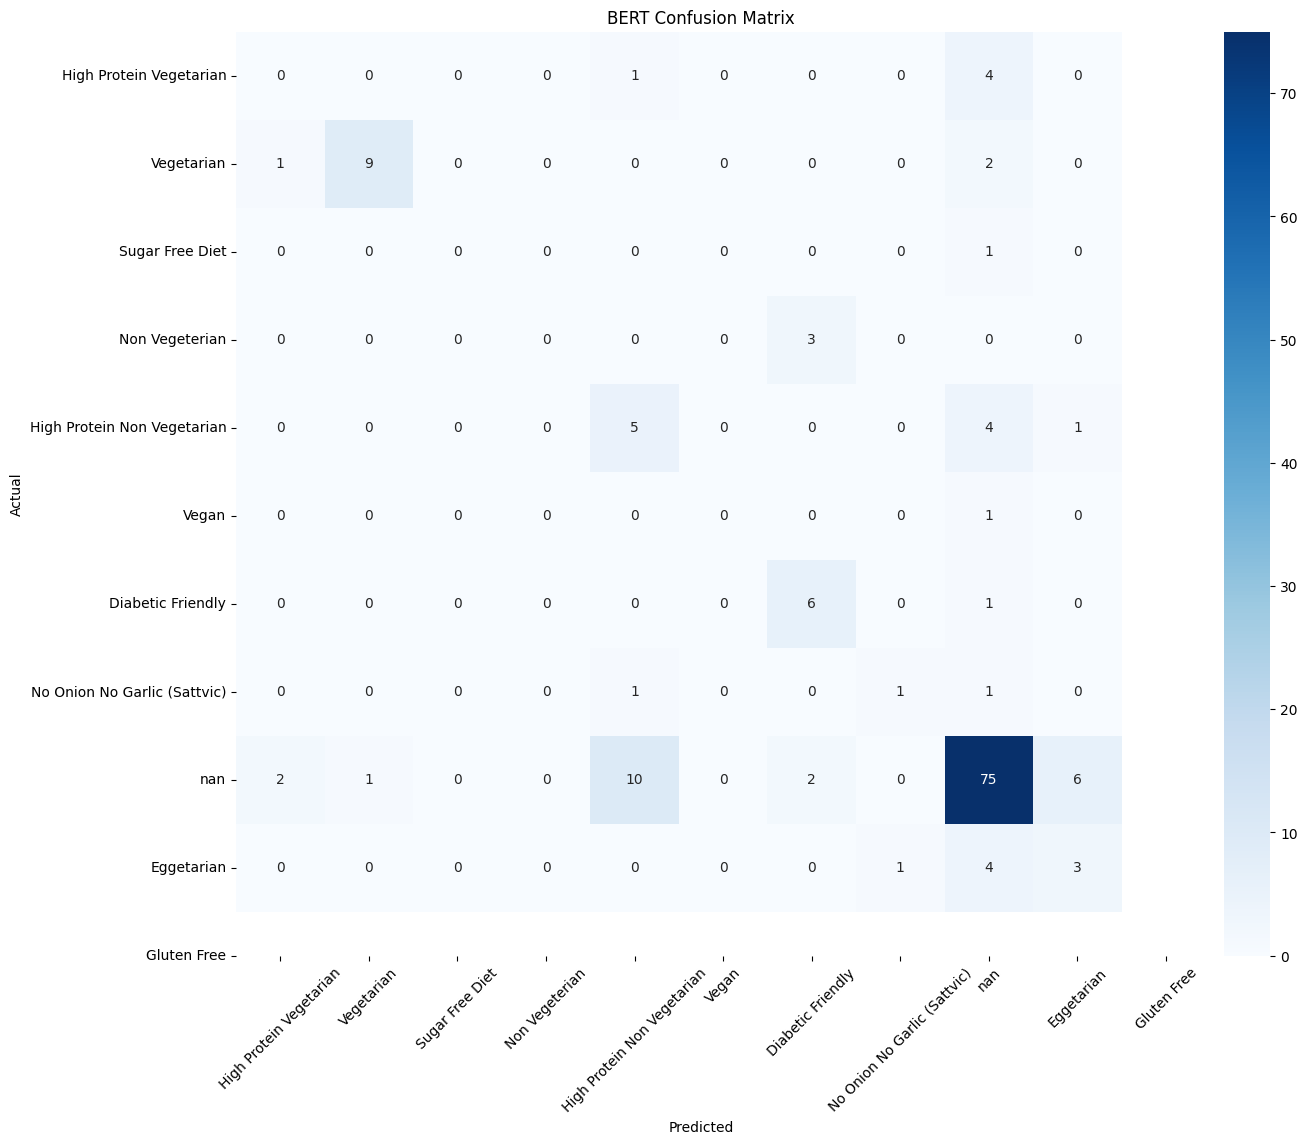


Sample Prediction: Vegetarian


In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 15
MODEL_NAME = 'bert-base-uncased'

# Load and preprocess data
df = pd.read_csv('Food_Recipe.csv')
df['diet'] = df['diet'].fillna('nan')
df = df.dropna(subset=['instructions'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['instructions'], df['diet'],
    test_size=0.2,
    random_state=42,
    stratify=df['diet']
)

# Create label map
unique_diets = df['diet'].unique()
label2id = {diet:i for i, diet in enumerate(unique_diets)}
id2label = {i:diet for i, diet in enumerate(unique_diets)}

# Dataset class
class RecipeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label2id[label], dtype=torch.long)
        }

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

# Create data loaders
train_dataset = RecipeDataset(X_train, y_train, tokenizer, MAX_LEN)
test_dataset = RecipeDataset(X_test, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}')

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert IDs back to labels
y_pred = [id2label[p] for p in all_preds]
y_true = [id2label[l] for l in all_labels]

# Print metrics
print("\nBERT Model Performance:")
print("=" * 60)
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
plt.figure(figsize=(15, 12))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_diets,
            yticklabels=unique_diets)
plt.title('BERT Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Example prediction
def predict_diet(text):
    encoding = tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)

    pred_id = torch.argmax(outputs.logits, dim=1).item()
    return id2label[pred_id]

sample_recipe = "Blend silken tofu, cocoa powder, and maple syrup for a healthy chocolate mousse"
print(f"\nSample Prediction: {predict_diet(sample_recipe)}")

In [3]:
# After training, save all necessary components
import json

# Save model and tokenizer
model.save_pretrained("recipe_bert_model")
tokenizer.save_pretrained("recipe_bert_model")

# Save label mappings
with open("recipe_bert_model/label2id.json", "w") as f:
    json.dump(label2id, f)

with open("recipe_bert_model/id2label.json", "w") as f:
    json.dump(id2label, f)

print("Model and artifacts saved successfully!")

Model and artifacts saved successfully!


In [4]:
import shutil
from google.colab import files
# Path to your folder
folder_path = 'recipe_bert_model'

# Output zip file
output_path = 'recipe_bert_model.zip'

# Compress the folder
shutil.make_archive(output_path.replace('.zip', ''), 'zip', folder_path)

files.download(output_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import json

class DietClassifier:
    def __init__(self, model_path):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = BertForSequenceClassification.from_pretrained(model_path).to(self.device)
        self.tokenizer = BertTokenizer.from_pretrained(model_path)
        self.model.eval()

        # Load label mappings
        with open(f"{model_path}/label2id.json", "r") as f:
            self.label2id = json.load(f)
        self.id2label = {int(k):v for k,v in json.load(open(f"{model_path}/id2label.json")).items()}

    def predict(self, text, max_length=128):
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=max_length,
            add_special_tokens=True,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        with torch.no_grad():
            inputs = {
                'input_ids': encoding['input_ids'].to(self.device),
                'attention_mask': encoding['attention_mask'].to(self.device)
            }
            outputs = self.model(**inputs)
            pred_id = torch.argmax(outputs.logits, dim=1).item()

        return self.id2label[pred_id]

# Example usage
if __name__ == "__main__":
    # Initialize classifier
    classifier = DietClassifier("recipe_bert_model")

    # Sample prediction
    sample_recipe = """
    first take some boiling water and put the fish in a bowl. add spices to the fish body and fry it for half an hour
    """

    prediction = classifier.predict(sample_recipe)
    print(f"Predicted Dietary Category: {prediction}")

Predicted Dietary Category: Non Vegeterian
